<a href="https://colab.research.google.com/github/sai-teja-ponugoti/Face-Mask-Detection/blob/main/dev%20jupyter%20notebooks/dev_Image_face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

# using this instead of CV2 to avoid crashing google colab
from google.colab.patches import cv2_imshow

loading face detector model...
loading face mask detector model...
computing face detections...


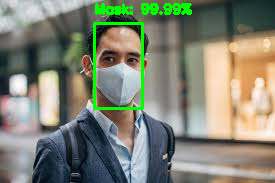

In [15]:
# loading the pretrained face detection OpenCV2 caffe model
print("loading face detector model...")
# model architecture (i.e., the layers) file path
prototxtPath = os.path.sep.join(["/content/", "deploy.prototxt"])
# model weights file path
weightsPath = os.path.sep.join(["/content/", "res10_300x300_ssd_iter_140000.caffemodel"])
# loading the pretrained face detection model using above architecture ad weights
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask classifier built using dev_train_mask_detector file
print("loading face mask detector model...")
model = load_model("/content/mask_detector_new.model")

# load the input test image from disk
image = cv2.imread("/content/index.jpeg")
# making a copy of image and finding the image spatial dimensions
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image to pass to the network
# using standard weights for the face detection model for image preprocessing
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
    (104.0, 177.0, 123.0))

# obtain the face detections by passing the blob through the network 
print("computing face detections...")
net.setInput(blob)
detections = net.forward()

# loop over the detections to classify them and form bounding boxes and labels
for i in range(0, detections.shape[2]):
    # extract only confident detections using the confidence/probability 
    # associated with the detection
    confidence = detections[0, 0, i, 2]

    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence 0.5 or input variable
    if confidence > 0.5:
        # compute the (x, y)-coordinates of the bounding box for the face
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # making sure bounding box is inside the dimensions of the image
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        # extract the face region of interest(ROI), convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocessing it to be compatible with 
        # face mask classification model
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)

        # Passing the pre-processed image with classification model to check if there is a mask or not
        (mask, withoutMask) = model.predict(face)[0]

        # find the class and associated colour to use for the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # include the probability of prediction in the label of the bounding box
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # forming bounding box rectangle and display the label the output image frame
        cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
cv2_imshow(image)

In [ ]:
)